# Install Dependencies

In [1]:
# %%capture
# !pip install rasterio==1.3.8
# !pip install torchgeo==0.4.1
# !pip install tiler==0.5.7
# !pip install kornia==0.6.12
# !pip install lightning==1.9.5

# Prepare Datamodule

In [9]:
from lightning.pytorch import Trainer
from lightning.pytorch.callbacks import EarlyStopping, ModelCheckpoint
from lightning.pytorch.loggers import TensorBoardLogger
import torch
import random
import numpy as np
from OpenMineChangeDetection.datasets import OSCDDataModule, OSCD_Chipped
from torchgeo.transforms import AugmentationSequential
import kornia.augmentation as K


if torch.cuda.is_available():
  device = torch.device('cuda')
else:
  device = torch.device('cpu')

print(f"device: {device}")

torch.manual_seed(543)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(543)
random.seed(543)
np.random.seed(543)

device: cuda


In [2]:
datamodule = OSCDDataModule(
    batch_size=16, 
)

datamodule.setup('fit')

datamodule.aug = AugmentationSequential(
    K.RandomHorizontalFlip(p=0.5, same_on_batch=False),
    K.RandomVerticalFlip(p=0.5, same_on_batch=False),
    K.RandomGaussianNoise(mean=0.0, std=0.1, same_on_batch=False),
    K.RandomAffine(degrees=30, translate=(0.1, 0.1), scale=(0.8, 1.2), same_on_batch=False),
    K.Normalize(mean=datamodule.mean, std=datamodule.std),
    data_keys=["image", "mask"],
)

# Prepare TinyCD Model For Training

In [3]:
from OpenMineChangeDetection.TinyCD.models.cd_lightning import ChangeDetectorLightningModule
pl_model = ChangeDetectorLightningModule(freeze_backbone=False)
pl_model.change_detector.load_state_dict(torch.load("OpenMineChangeDetection/TinyCD/pretrained_models/levir_best.pth", map_location=device))

# for param in pl_model.parameters():
#     param.requires_grad = False

# layers_to_unfreeze = ['_classify']

# for name, param in pl_model.named_parameters():
#     contains_name = False
#     for layer in layers_to_unfreeze:
#         if layer in name:
#             contains_name = True
#     if contains_name:
#         print(f'Unfreezing layer {name}.')
#         param.requires_grad = True

<All keys matched successfully>

In [4]:
batch_size = 16
num_workers = 0
max_epochs = 30
fast_dev_run = False

In [5]:
accelerator = "gpu" if torch.cuda.is_available() else "cpu"

checkpoint_callback = ModelCheckpoint(
    monitor="val_loss", 
    dirpath='checkpoints', 
    save_top_k=3, 
    save_last=True,
    filename='model-{epoch:02d}-{val_loss:.2f}',
    mode='min'
)

early_stopping_callback = EarlyStopping(monitor="val_loss", min_delta=0.00, patience=20)
logger = TensorBoardLogger(save_dir="experiments_tinycd", name="saved_logs")

trainer = Trainer(
    accelerator=accelerator,
    callbacks=[checkpoint_callback, early_stopping_callback],
    fast_dev_run=fast_dev_run,
    log_every_n_steps=5,
    logger=logger,
    min_epochs=5,
    max_epochs=max_epochs,
    # precision=16
)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


# Train

In [6]:
trainer.fit(model=pl_model, datamodule=datamodule)

/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/lightning/pytorch/callbacks/model_checkpoint.py:613: UserWarning: Checkpoint directory /teamspace/studios/this_studio/checkpoints exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params
-----------------------------------------------------
0 | change_detector | ChangeClassifier | 285 K 
1 | criterion       | BCELoss          | 0     
-----------------------------------------------------
285 K     Trainable params
0         Non-trainable params
285 K     Total params
1.141     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=30` reached.


# Test

In [7]:
trainer.test(model=pl_model, datamodule=datamodule)

/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/tiler/tiler.py:236: UserWarning: Tiler (mode=drop, overlap=(5, 128, 128)) will split data_shape torch.Size([6, 241, 385]) into zero tiles (tile_shape=(6, 256, 256)).
  warnings.warn(
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, test_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_loss         │    0.1824938803911209     │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 0.1824938803911209}]

In [8]:
from OpenMineChangeDetection.utils import test_TinyCD

datamodule.setup('test')
datamodule.setup('validate')
test_TinyCD(pl_model, device, datamodule, threshold=0.4)

/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/tiler/tiler.py:236: UserWarning: Tiler (mode=drop, overlap=(5, 128, 128)) will split data_shape torch.Size([6, 241, 385]) into zero tiles (tile_shape=(6, 256, 256)).
  warnings.warn(
100%|██████████| 6/6 [00:02<00:00,  2.15it/s]


{'acc': 0.9518879215891557,
 'miou': 0.547287097542941,
 'mf1': 0.6127406111147663,
 'iou_0': 0.9514983070967036,
 'iou_1': 0.14307588798917856,
 'F1_0': 0.9751463739396576,
 'F1_1': 0.2503348482898749,
 'precision_0': 0.9574575600592052,
 'precision_1': 0.5654241106503457,
 'recall_0': 0.993501207542564,
 'recall_1': 0.16075325274996402,
 'loss': tensor(0.1681, device='cuda:0')}

# Visualize Predictions

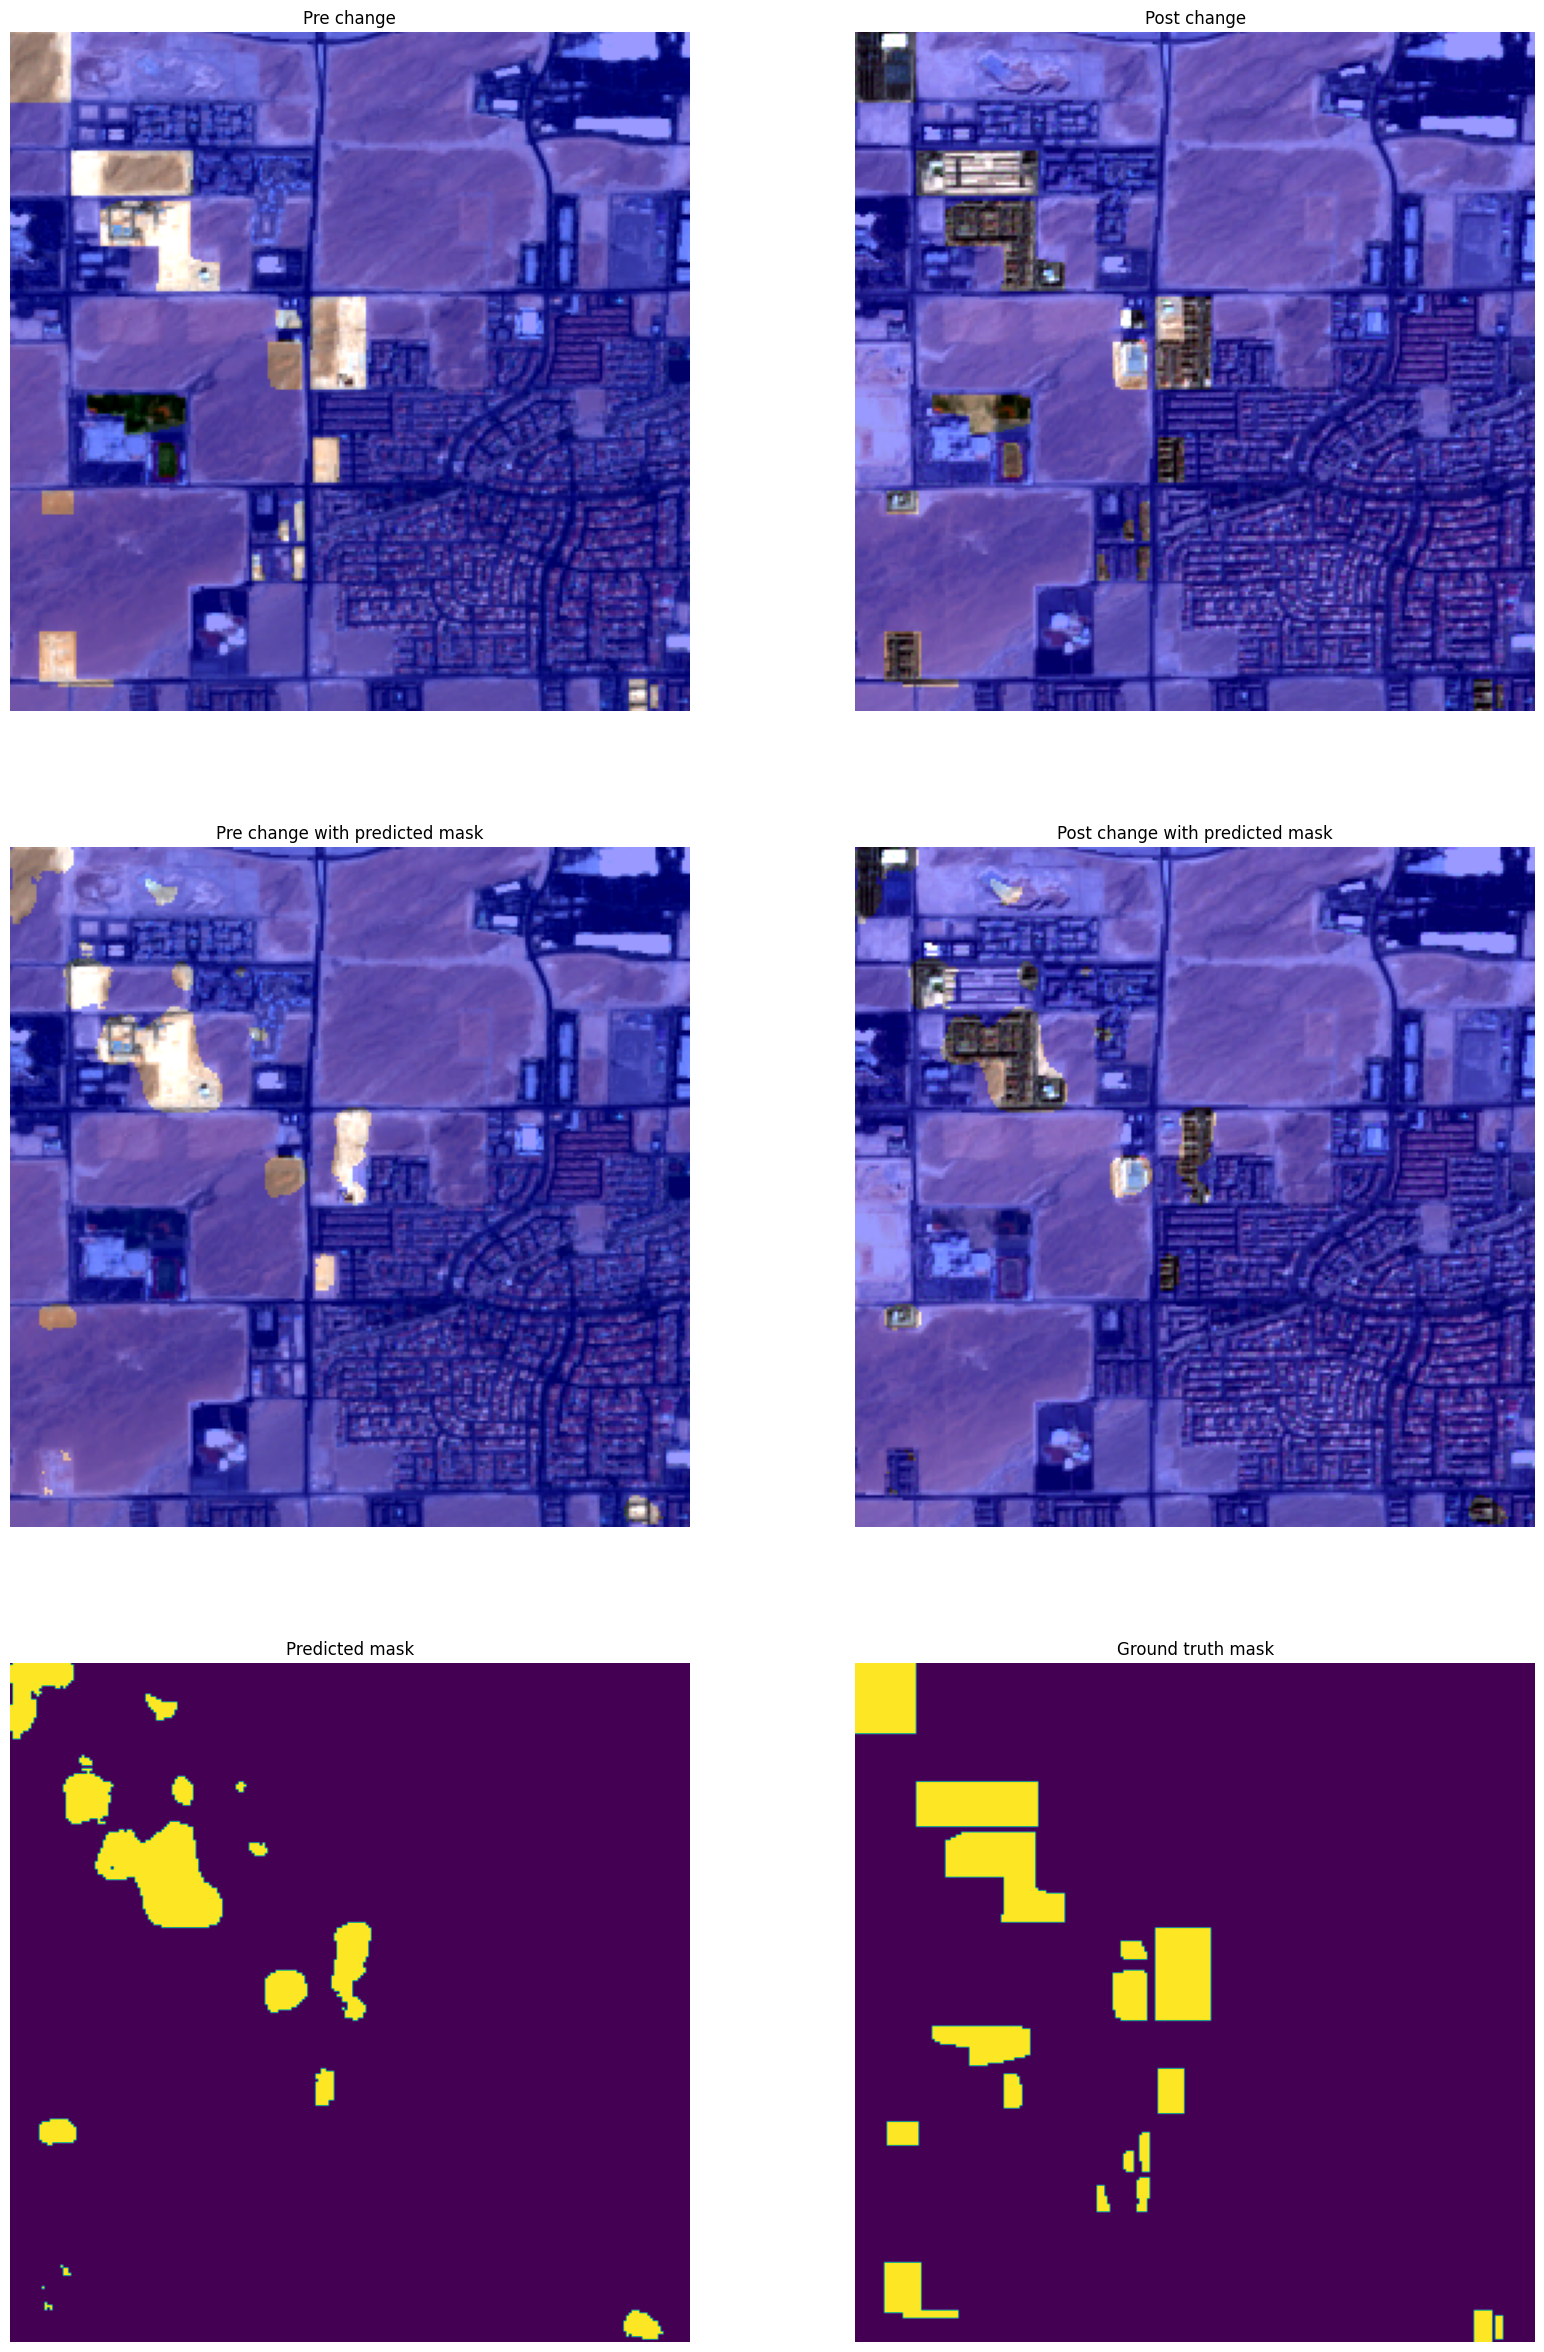

In [16]:
from OpenMineChangeDetection.utils import plot_prediction
from OpenMineChangeDetection.datasets.OSCD_Chipped import OSCD_Chipped

normalize_sample = OSCD_Chipped.GetNormalizeTransform(bands='rgb')
dataset = OSCD_Chipped(split='test', bands='rgb')

plot_prediction(pl_model, normalize_sample(dataset[0]), bands="rgb", colormap="blue", threshold=0.3)

In [15]:
from OpenMineChangeDetection.utils import get_mask_preds_tinycd, evaluate_model, plot_pr_curve

stats = evaluate_model(pl_model.to(device).eval(), datamodule.test_dataloader(), get_mask_preds_tinycd, device, threshold=0.10)

  0%|          | 0/6 [00:00<?, ?it/s]


TypeError: Expected input of [torch.float16, torch.float32, torch.float64]. Got torch.int64

In [ ]:
print(stats)

In [ ]:
plot_pr_curve(stats['PRC'])

In [ ]:
stats = evaluate_model(pl_model.eval(), datamodule.val_dataloader(), get_mask_preds_tinycd, device, threshold=0.20)
print(stats)

In [ ]:
plot_pr_curve(stats['PRC'])